In [105]:
def preProcess(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)  # ADD GAUSSIAN BLUR
    imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)  # APPLY ADAPTIVE THRESHOLD
    return imgThreshold

In [106]:
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

In [107]:
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area

In [108]:
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [109]:
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                cv2.putText(img, str(numbers[(y*9)+x]),(x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,2, color, 2, cv2.LINE_AA)
    return img

In [110]:
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)
    return img

In [111]:
def solve(matrix):
    M = 9
    solved=[]
    def puzzle(a):
        for i in range(M):
            row=[]
            for j in range(M):
                row.append(a[i][j])
            solved.append(row)    
    def solve(grid, row, col, num):
        for x in range(9):
            if grid[row][x] == num:
                return False
        for x in range(9):
            if grid[x][col] == num:
                return False
        startRow = row - row % 3
        startCol = col - col % 3
        for i in range(3):
            for j in range(3):
                if grid[i + startRow][j + startCol] == num:
                    return False
        return True
    def Suduko(grid, row, col):
        if (row == M - 1 and col == M):
            return True
        if col == M:
            row += 1
            col = 0
        if grid[row][col] > 0:
            return Suduko(grid, row, col + 1)
        for num in range(1, M + 1, 1): 
            if solve(grid, row, col, num):
                grid[row][col] = num
                if Suduko(grid, row, col + 1):
                    return True
                grid[row][col] = 0
        return False
    '''0 means the cells where no value is assigned'''
    if (Suduko(matrix, 0, 0)):
        puzzle(matrix)
    return solved

In [130]:
def sudoku(path):
    # Load the HOG decision tree model
    with open('decision_tree_model.pkl', 'rb') as file:
        hog_model = pickle.load(file)
    # Load and preprocess the Sudoku image
    heightImg = 450
    widthImg = 450
    img = cv2.imread(path)
    img = cv2.resize(img, (widthImg, heightImg))  # RESIZE IMAGE TO MAKE IT A SQUARE IMAGE
    imgBlank = np.zeros((heightImg, widthImg, 3), np.uint8)  # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
    imgThreshold = preProcess(img)
    imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
    cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3) # DRAW ALL DETECTED CONTOURS
    biggest, maxArea = biggestContour(contours) # FIND THE BIGGEST CONTOUR
    #print(biggest)
    if biggest.size != 0:
        biggest = reorder(biggest)
        #print(biggest)
        cv2.drawContours(imgBigContour, biggest, -1, (0, 0, 255), 25) # DRAW THE BIGGEST CONTOUR
        pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2) # GER
        imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
        imgDetectedDigits = imgBlank.copy()
        imgWarpColored = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)

        imgSolvedDigits = imgBlank.copy()
        boxes = splitBoxes(imgWarpColored)
        #print(len(boxes))
        
    numbers = predict_digit(boxes, hog_model)  # Use your HOG model for digit detection
    plt.subplot(1,3,1)
    plt.imshow(imgWarpColored,cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(boxes[17],cmap="gray")
    imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, color=(255, 0, 255)) 
    plt.subplot(1,3,3)
    plt.imshow(imgDetectedDigits,cmap="gray")

In [127]:
def predict_digit(boxes, model, threshold=0.8):
    digits = []
    for box in boxes:
        # Preprocess the box (resize, convert to grayscale, etc.)
        resized_img = cv2.resize(box, (64, 128))  # Resize to match HOG feature size
        
        # Extract HOG features
        hog = cv2.HOGDescriptor()
        hog_feature = hog.compute(resized_img)
        
        # Reshape HOG feature array to match the format expected by the model
        hog_feature = hog_feature.reshape(1, -1)[:,:784]  # Resize to match expected dimensions
        
        # Predict digit using the trained model
        digit_probabilities = model.predict_proba(hog_feature)[0]
        
        # Check if the maximum probability is above the threshold
        if np.max(digit_probabilities) < threshold:
            predicted_digit = 0  # Assign 0 if maximum probability is below threshold
        else:
            predicted_digit = np.argmax(digit_probabilities) # Index starts from 0, so add 1
        
        digits.append(predicted_digit)
    
    return digits


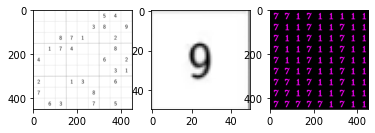

In [131]:
sudoku("C:\\Users\\RITIKA\\Desktop\\2nd year\\sem 4\\Sodoku project\\ML_sudoku_try.webp")

Need to improve on grid extraction and detection part.